In [39]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

pd.set_option('max_columns', None)

### Load data

In [40]:
folder = 'finals_2021_1'
path = '/home/danguyen/data/powertac/finals_2021/{}/analysis'.format(folder)
cwd = Path(path)
tf_transactions = pd.read_csv(cwd/"{}.tariff-transactions.csv".format(folder), delimiter=";")
balancing_actions = pd.read_csv(cwd/"{}.broker-balancing-actions.csv".format(folder), delimiter=";")


### Clean data

In [50]:
# remove leading and trailing whitespaces in column names and values

def rem_ws_col(df):
    df.columns = df.columns.str.strip()
    return df

def rem_ws_val(df):
    df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
    return df

tf_transactions = rem_ws_col(tf_transactions)
balancing_actions = rem_ws_col(balancing_actions)

tf_transactions[['broker-name', 'tariff-type', 'transaction-type']].astype(str)
tf_transactions = rem_ws_val(tf_transactions)


### Transform datasets

We assume for now regulation = 1 means it is a balancing event. 
Afterwards we aggregate per broker per timeslot the powertype (tariff-type) and whether it is storing or curtailment (transaction-type).

In [51]:

tf_reg = tf_transactions[tf_transactions['transaction-regulation'] == 1].copy()

tf_reg = tf_reg[['timeslot'
                , 'broker-name'
                , 'tariff-type'
                , 'transaction-type'
                , 'transaction-kWh'
                , 'transaction-charge']]
tf_reg_agg = tf_reg.groupby(by = ['timeslot'
                            , 'broker-name'
                            , 'tariff-type'
                            , 'transaction-type'], as_index=False).sum().copy()
final_tf = tf_reg_agg[tf_reg_agg['transaction-kWh'] != 0].copy()
final_tf


,timeslot,broker-name,tariff-type,transaction-type,transaction-kWh,transaction-charge
1,362,TUC_TAC,THERMAL_STORAGE_CONSUMPTION,PRODUCE,2361.981312,-172.562970
3,363,TUC_TAC,THERMAL_STORAGE_CONSUMPTION,PRODUCE,2248.415805,-164.266037
5,364,TUC_TAC,THERMAL_STORAGE_CONSUMPTION,PRODUCE,1944.210139,-142.041207
7,365,TUC_TAC,THERMAL_STORAGE_CONSUMPTION,PRODUCE,3738.884094,-273.157515
9,366,TUC_TAC,THERMAL_STORAGE_CONSUMPTION,PRODUCE,3106.892532,-226.985117
...,...,...,...,...,...,...
3253,1716,TUC_TAC,THERMAL_STORAGE_CONSUMPTION,PRODUCE,5892.721818,-430.513813
3254,1717,CrocodileAgent2020,STORAGE,CONSUME,-1.788757,0.268313
3255,1717,IS3,BATTERY_STORAGE,CONSUME,-1200.000000,69.606711
3256,1718,CrocodileAgent2020,STORAGE,CONSUME,-3.276598,0.491490


Test if there are multiple regulation power types used in a single timeslot

In [52]:
test_tf = final_tf.groupby(by = ['timeslot'
                            , 'broker-name'
                            ], as_index=False).sum().copy()
test_tf

,timeslot,broker-name,transaction-kWh,transaction-charge
0,362,TUC_TAC,2361.981312,-172.562970
1,363,TUC_TAC,2248.415805,-164.266037
2,364,TUC_TAC,1944.210139,-142.041207
3,365,TUC_TAC,3738.884094,-273.157515
4,366,TUC_TAC,3106.892532,-226.985117
...,...,...,...,...
2359,1716,TUC_TAC,5892.721818,-430.513813
2360,1717,CrocodileAgent2020,-1.788757,0.268313
2361,1717,IS3,-1200.000000,69.606711
2362,1718,CrocodileAgent2020,-3.276598,0.491490


Collapse the dataframe to have individual broker regulation per timeslot observations

In [53]:
# collapse the dataframe into less columns by subselecting the dataframes, rename and concat the subdataframes
# consider only where regUsed != 0

df = balancing_actions.copy()

column_sets = [
    ['ts', 'totalImbalance', 'default broker', 'netLoad', 'regOffered', 'regUsed', 'baseCost', 'p1', 'p2'],
    ['ts', 'totalImbalance', 'CrocodileAgent2020', 'netLoad.1', 'regOffered.1', 'regUsed.1','baseCost.1', 'p1.1', 'p2.1'],
    ['ts', 'totalImbalance', 'COLDPOWER2021', 'netLoad.2', 'regOffered.2', 'regUsed.2', 'baseCost.2', 'p1.2', 'p2.2'],
    ['ts', 'totalImbalance', 'VidyutVanika', 'netLoad.3', 'regOffered.3', 'regUsed.3', 'baseCost.3', 'p1.3', 'p2.3'],
    ['ts', 'totalImbalance', 'IS3', 'netLoad.4', 'regOffered.4', 'regUsed.4', 'baseCost.4', 'p1.4', 'p2.4'],
    ['ts', 'totalImbalance', 'TUC_TAC', 'netLoad.5', 'regOffered.5', 'regUsed.5', 'baseCost.5', 'p1.5', 'p2.5'],
    ['ts', 'totalImbalance', 'Mertacor2021', 'netLoad.6', 'regOffered.6', 'regUsed.6', 'baseCost.6', 'p1.6', 'p2.6']
]

default_broker = df[column_sets[0]]
croc_agent = df[column_sets[1]]
coldpower = df[column_sets[2]]
vv = df[column_sets[3]]
is3 = df[column_sets[4]]
tuc_tac = df[column_sets[5]]
mertacor = df[column_sets[6]]

df_sets = [default_broker, croc_agent, coldpower, vv, is3, tuc_tac, mertacor]

for df in df_sets:
    df.columns = ['ts', 'totalImbalance', 'broker', 'netLoad', 'regOffered', 'regUsed', 'baseCost', 'p1', 'p2']

final_ba = pd.concat(df_sets)
final_ba = final_ba[final_ba["regUsed"] != 0 ]
final_ba

,ts,totalImbalance,broker,netLoad,regOffered,regUsed,baseCost,p1,p2
6,368,7800.1454,CrocodileAgent2020,-1176.6784,-21.3416,-21.3416,34.9099,-26.5582,-0.5184
7,369,10473.1373,CrocodileAgent2020,-1175.2770,-23.0584,-23.0584,34.0314,-28.7303,-0.4821
8,370,7910.8427,CrocodileAgent2020,108.6552,-22.0000,-22.0000,-3.0989,2.8415,-0.4735
9,371,2319.2942,CrocodileAgent2020,122.0125,-23.8320,-23.8320,-4.0068,4.0023,-0.7280
15,377,706.6961,CrocodileAgent2020,704.0833,-17.0560,-17.0560,-24.6080,24.0260,-0.5846
...,...,...,...,...,...,...,...,...,...
1347,1709,16266.0400,TUC_TAC,-1432.6330,-5862.3624,-2220.3910,27.6451,-3.7735,-11.6705
1351,1713,17094.9008,TUC_TAC,2731.7338,-4447.5904,-3371.7469,-49.5573,9.7769,-14.9408
1352,1714,15544.2776,TUC_TAC,1183.9542,-4710.9329,-1799.9449,-23.3455,0.8189,-10.7578
1353,1715,-6262.0299,TUC_TAC,-16336.6395,4938.8566,4938.8566,-2743.9118,-2743.9118,824.2150


Merge the datasets on timeslot and broker

In [62]:
final_df = final_ba.merge(final_tf, left_on=['ts', 'broker'], right_on=['timeslot', 'broker-name'])
final_df

,ts,totalImbalance,broker,netLoad,regOffered,regUsed,baseCost,p1,p2,timeslot,broker-name,tariff-type,transaction-type,transaction-kWh,transaction-charge
0,368,7800.1454,CrocodileAgent2020,-1176.6784,-21.3416,-21.3416,34.9099,-26.5582,-0.5184,368,CrocodileAgent2020,STORAGE,CONSUME,-21.341584,3.201238
1,369,10473.1373,CrocodileAgent2020,-1175.2770,-23.0584,-23.0584,34.0314,-28.7303,-0.4821,369,CrocodileAgent2020,STORAGE,CONSUME,-23.058416,3.458762
2,370,7910.8427,CrocodileAgent2020,108.6552,-22.0000,-22.0000,-3.0989,2.8415,-0.4735,370,CrocodileAgent2020,STORAGE,CONSUME,-22.000000,3.300000
3,371,2319.2942,CrocodileAgent2020,122.0125,-23.8320,-23.8320,-4.0068,4.0023,-0.7280,371,CrocodileAgent2020,STORAGE,CONSUME,-23.832043,3.574806
4,377,706.6961,CrocodileAgent2020,704.0833,-17.0560,-17.0560,-24.6080,24.0260,-0.5846,377,CrocodileAgent2020,STORAGE,CONSUME,-17.055964,2.558395
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2359,1709,16266.0400,TUC_TAC,-1432.6330,-5862.3624,-2220.3910,27.6451,-3.7735,-11.6705,1709,TUC_TAC,THERMAL_STORAGE_CONSUMPTION,CONSUME,-2220.391002,47.781900
2360,1713,17094.9008,TUC_TAC,2731.7338,-4447.5904,-3371.7469,-49.5573,9.7769,-14.9408,1713,TUC_TAC,THERMAL_STORAGE_CONSUMPTION,CONSUME,-3371.746938,72.558606
2361,1714,15544.2776,TUC_TAC,1183.9542,-4710.9329,-1799.9449,-23.3455,0.8189,-10.7578,1714,TUC_TAC,THERMAL_STORAGE_CONSUMPTION,CONSUME,-1799.944926,38.734074
2362,1715,-6262.0299,TUC_TAC,-16336.6395,4938.8566,4938.8566,-2743.9118,-2743.9118,824.2150,1715,TUC_TAC,THERMAL_STORAGE_CONSUMPTION,PRODUCE,4938.856644,-360.825790


Check if there is any large deviation from the energy value in balancing action dataset and tariff transaction dataset

In [61]:
final_df['diff'] = abs(abs(final_df['regUsed'] - final_df['transaction-kWh'])/final_df['transaction-kWh'])
final_df.sort_values('diff', ascending = False)

,ts,totalImbalance,broker,netLoad,regOffered,regUsed,baseCost,p1,p2,timeslot,broker-name,tariff-type,transaction-type,transaction-kWh,transaction-charge,diff
68,499,10749.4135,CrocodileAgent2020,-3253.1382,-0.0272,-0.0272,130.1274,-130.1023,-0.0008,499,CrocodileAgent2020,STORAGE,CONSUME,-0.027183,0.004077,0.000636
595,1565,2026.6883,CrocodileAgent2020,-5097.9793,-0.0272,-0.0272,172.0185,-171.7917,-0.0009,1565,CrocodileAgent2020,STORAGE,CONSUME,-0.027183,0.004077,0.000636
532,1430,22768.1493,CrocodileAgent2020,-7273.9113,-0.2437,-0.2437,113.5662,-107.7453,-0.0052,1430,CrocodileAgent2020,STORAGE,CONSUME,-0.243654,0.036548,0.000187
88,527,4594.6965,CrocodileAgent2020,-645.6874,-0.0397,-0.0397,19.7849,-19.7745,-0.0010,527,CrocodileAgent2020,STORAGE,CONSUME,-0.039694,0.005954,0.000152
42,460,11959.7504,CrocodileAgent2020,-1349.7733,-0.0397,-0.0397,32.5525,-32.5486,-0.0005,460,CrocodileAgent2020,STORAGE,CONSUME,-0.039694,0.005954,0.000152
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
932,882,-6851.4418,IS3,4701.4500,1138.6500,1138.6500,892.3616,892.3616,220.1467,882,IS3,BATTERY_STORAGE,PRODUCE,1138.650000,-171.235732,0.000000
933,899,3659.6336,IS3,54631.3900,-1200.0000,-1200.0000,-2759.2694,2759.2694,-57.6737,899,IS3,BATTERY_STORAGE,CONSUME,-1200.000000,69.606711,0.000000
934,900,1441.9471,IS3,51187.2000,-1200.0000,-1200.0000,-2869.4548,2869.4548,-67.0295,900,IS3,BATTERY_STORAGE,CONSUME,-1200.000000,69.606711,0.000000
935,901,-14868.7278,IS3,37297.9900,1200.0000,1200.0000,12382.1958,12382.0168,410.1545,901,IS3,BATTERY_STORAGE,PRODUCE,1200.000000,-180.461844,0.000000


## KPI1: Boxplot - Imbalance fixed across brokers per power type

0.20271657996104847


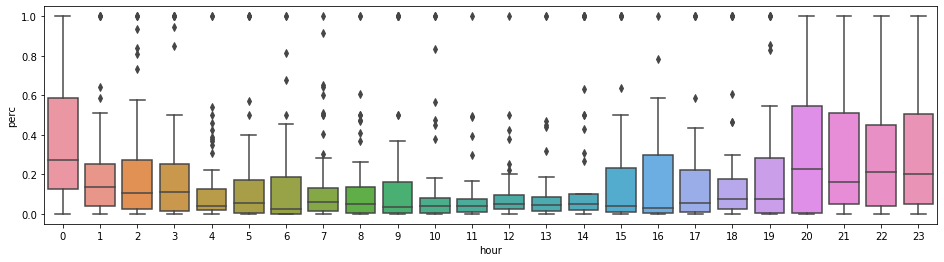

In [110]:
# consume is down-regulation or storage, produce is up-regulation or curtailment
# dots outside are determined outliers

kpi1_imbalance = final_df[['ts', 'totalImbalance']].copy()
kpi1_imbalance['totalImbalance'] = abs(kpi1_imbalance['totalImbalance'])
kpi1_imbalance = kpi1_imbalance.groupby(by = ['ts'], as_index = False).sum().copy()

kpi1_regulation = final_df[['ts', 'regUsed']].copy()
kpi1_regulation['regUsed'] = abs(kpi1_regulation['regUsed'])
kpi1_regulation = kpi1_regulation.groupby(by = ['ts'], as_index = False).sum().copy()

kpi1_perc = kpi1_imbalance.merge(kpi1_regulation, on = ['ts'])

kpi1_perc['hour'] = kpi1_perc['ts'] % 24
kpi1_perc['perc'] = kpi1_perc['regUsed'] / kpi1_perc['totalImbalance']

f = plt.figure(figsize=(16,4))

sns.boxplot(x='hour', y='perc', data=kpi1_perc)
print(kpi1_perc['perc'].mean())



0.20271657996104847
31620.29260413589


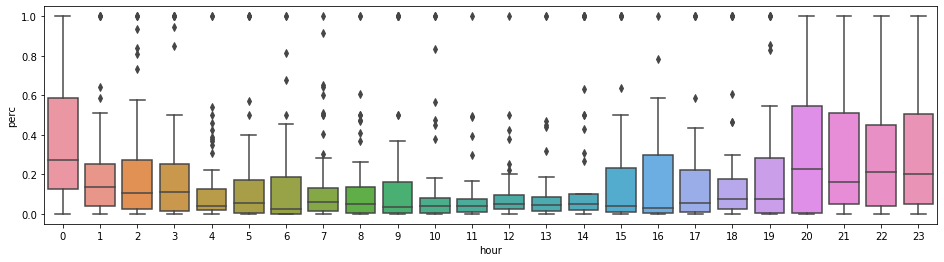

In [131]:
# up-regulation means shortage and therefore produce/ curtail energy resulting in more energy available

def kpi1_imb(imbalance):
    
    regex = r".*" if imbalance == 'both' else 'PRODUCE' if imbalance == 'up' else 'CONSUME'

    kpi1_imb_up = final_df[final_df['transaction-type'].str.contains(regex)][['ts', 'totalImbalance']].copy()
    kpi1_imb_up['totalImbalance'] = abs(kpi1_imb_up['totalImbalance'])
    kpi1_imb_up = kpi1_imb_up.groupby(by = ['ts'], as_index = False).sum().copy()

    kpi1_reg_up = final_df[final_df['transaction-type'].str.contains(regex)][['ts', 'regUsed']].copy()
    kpi1_reg_up['regUsed'] = abs(kpi1_reg_up['regUsed'])
    kpi1_reg_up = kpi1_reg_up.groupby(by = ['ts'], as_index = False).sum().copy()

    kpi1_perc = kpi1_imb_up.merge(kpi1_reg_up, on = ['ts'])

    kpi1_perc['hour'] = kpi1_perc['ts'] % 24
    kpi1_perc['perc'] = kpi1_perc['regUsed'] / kpi1_perc['totalImbalance']

    f = plt.figure(figsize=(16,4))

    sns.boxplot(x='hour', y='perc', data=kpi1_perc)
    print(kpi1_perc['perc'].mean())
    print(kpi1_perc['totalImbalance'].mean())
    
kpi1_imb('both')


### KPI1: Considering each imbalance type

0.3123502971860756
27050.28544793811


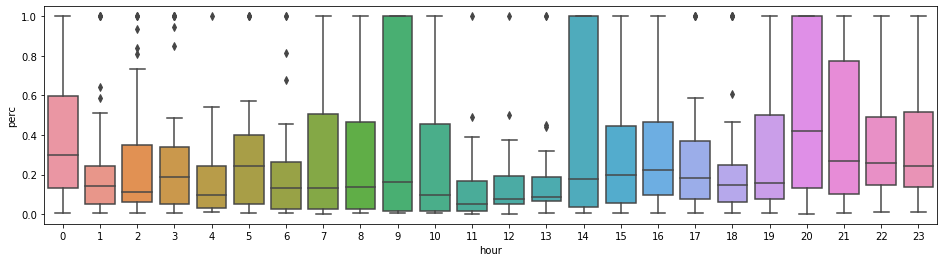

In [117]:
# up-regulation means shortage and therefore produce/ curtail energy resulting in more energy available

kpi1_imb_up = final_df[final_df['transaction-type'] == 'PRODUCE'][['ts', 'totalImbalance']].copy()
kpi1_imb_up['totalImbalance'] = abs(kpi1_imb_up['totalImbalance'])
kpi1_imb_up = kpi1_imb_up.groupby(by = ['ts'], as_index = False).sum().copy()

kpi1_reg_up = final_df[final_df['transaction-type'] == 'PRODUCE'][['ts', 'regUsed']].copy()
kpi1_reg_up['regUsed'] = abs(kpi1_reg_up['regUsed'])
kpi1_reg_up = kpi1_reg_up.groupby(by = ['ts'], as_index = False).sum().copy()

kpi1_perc = kpi1_imb_up.merge(kpi1_reg_up, on = ['ts'])

kpi1_perc['hour'] = kpi1_perc['ts'] % 24
kpi1_perc['perc'] = kpi1_perc['regUsed'] / kpi1_perc['totalImbalance']

f = plt.figure(figsize=(16,4))

sns.boxplot(x='hour', y='perc', data=kpi1_perc)
print(kpi1_perc['perc'].mean())
print(kpi1_perc['totalImbalance'].mean())


0.055526675866548324
37755.80394186849


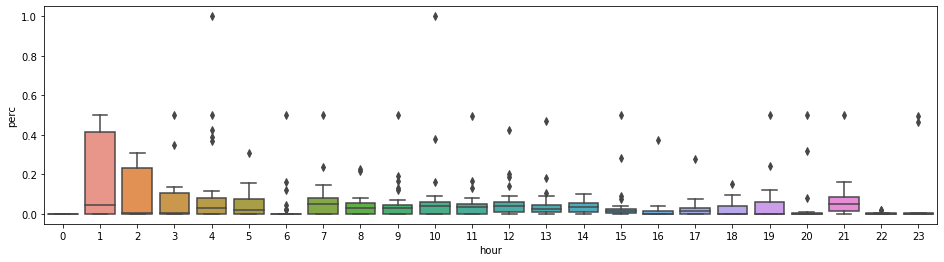

In [118]:
# down-regulation means excess and therefore consume/ storage energy resulting in more energy used


kpi1_imb_down = final_df[final_df['transaction-type'] == 'CONSUME'][['ts', 'totalImbalance']].copy()
kpi1_imb_down['totalImbalance'] = abs(kpi1_imb_down['totalImbalance'])
kpi1_imb_down = kpi1_imb_down.groupby(by = ['ts'], as_index = False).sum().copy()

kpi1_reg_down = final_df[final_df['transaction-type'] == 'CONSUME'][['ts', 'regUsed']].copy()
kpi1_reg_down['regUsed'] = abs(kpi1_reg_down['regUsed'])
kpi1_reg_down = kpi1_reg_down.groupby(by = ['ts'], as_index = False).sum().copy()

kpi1_perc = kpi1_imb_down.merge(kpi1_reg_down, on = ['ts'])

kpi1_perc['hour'] = kpi1_perc['ts'] % 24
kpi1_perc['perc'] = kpi1_perc['regUsed'] / kpi1_perc['totalImbalance']

f = plt.figure(figsize=(16,4))

sns.boxplot(x='hour', y='perc', data=kpi1_perc)
print(kpi1_perc['perc'].mean())
print(kpi1_perc['totalImbalance'].mean())


In [ ]:
kpi1_df_og = final_df[['ts', 'broker', 'regUsed', 'tariff-type', 'transaction-type', 'transaction-kWh']].copy()
kpi1_df_og['absImbalance'] = abs(kpi1_df_og['totalImbalance'])
kpi1_df_og['absRegulation'] = abs(kpi1_df_og['regUsed'])


kpi1_df = kpi1_df_og[['ts', 'absImbalance', ]]
kpi1_df_og['hour'] = kpi1_df_og['ts'] % 24
kpi1_df['hour'] = kpi1_df['ts'] % 24
kpi1_df['absImbalance'] = abs(kpi1_df['totalImbalance'])
kpi1_df['absRegulation'] = abs(kpi1_df['regUsed'])
kpi1_df['fixedImbalance'] = kpi1_df['absRegulation']/kpi1_df['absImbalance']
kpi1_df

In [76]:
kpi1_df['tariff-type'].unique()

array(['STORAGE', 'BATTERY_STORAGE', 'THERMAL_STORAGE_CONSUMPTION'],
      dtype=object)

In [79]:
kpi1_df[kpi1_df['tariff-type'] == 'THERMAL_STORAGE_CONSUMPTION']['transaction-type'].unique()

array(['PRODUCE', 'CONSUME'], dtype=object)

In [82]:
kpi1_df[kpi1_df['totalImbalance'] > 0]['transaction-type'].unique()

array(['CONSUME'], dtype=object)

In [116]:
final_df

,ts,totalImbalance,broker,netLoad,regOffered,regUsed,baseCost,p1,p2,timeslot,broker-name,tariff-type,transaction-type,transaction-kWh,transaction-charge
0,368,7800.1454,CrocodileAgent2020,-1176.6784,-21.3416,-21.3416,34.9099,-26.5582,-0.5184,368,CrocodileAgent2020,STORAGE,CONSUME,-21.341584,3.201238
1,369,10473.1373,CrocodileAgent2020,-1175.2770,-23.0584,-23.0584,34.0314,-28.7303,-0.4821,369,CrocodileAgent2020,STORAGE,CONSUME,-23.058416,3.458762
2,370,7910.8427,CrocodileAgent2020,108.6552,-22.0000,-22.0000,-3.0989,2.8415,-0.4735,370,CrocodileAgent2020,STORAGE,CONSUME,-22.000000,3.300000
3,371,2319.2942,CrocodileAgent2020,122.0125,-23.8320,-23.8320,-4.0068,4.0023,-0.7280,371,CrocodileAgent2020,STORAGE,CONSUME,-23.832043,3.574806
4,377,706.6961,CrocodileAgent2020,704.0833,-17.0560,-17.0560,-24.6080,24.0260,-0.5846,377,CrocodileAgent2020,STORAGE,CONSUME,-17.055964,2.558395
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2359,1709,16266.0400,TUC_TAC,-1432.6330,-5862.3624,-2220.3910,27.6451,-3.7735,-11.6705,1709,TUC_TAC,THERMAL_STORAGE_CONSUMPTION,CONSUME,-2220.391002,47.781900
2360,1713,17094.9008,TUC_TAC,2731.7338,-4447.5904,-3371.7469,-49.5573,9.7769,-14.9408,1713,TUC_TAC,THERMAL_STORAGE_CONSUMPTION,CONSUME,-3371.746938,72.558606
2361,1714,15544.2776,TUC_TAC,1183.9542,-4710.9329,-1799.9449,-23.3455,0.8189,-10.7578,1714,TUC_TAC,THERMAL_STORAGE_CONSUMPTION,CONSUME,-1799.944926,38.734074
2362,1715,-6262.0299,TUC_TAC,-16336.6395,4938.8566,4938.8566,-2743.9118,-2743.9118,824.2150,1715,TUC_TAC,THERMAL_STORAGE_CONSUMPTION,PRODUCE,4938.856644,-360.825790
